In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
import pickle
import seaborn as sns
import json
from imblearn.over_sampling import SMOTE
import plotly.express as px


# I - Préparation des Données 

In [2]:
# Extraction des données d’intérêt
file_arbre = 'Data_Arbre.csv'
arbre = pd.read_csv(file_arbre)

# Les colonnes pertinentes
colonnes_pertinentes = ["longitude", "latitude", "haut_tot", "haut_tronc", "tronc_diam", "fk_arb_etat", "age_estim"]
data_arbre = arbre[colonnes_pertinentes].copy()
print("\nDonnées avant transformation:")
print(data_arbre.head())

# Transformation de 'fk_arb_etat' en variable binaire
data_arbre['fk_arb_etat'] = (data_arbre['fk_arb_etat'] == 'Essouché').astype(int)
print("\nDonnées après transformation:")
print(data_arbre.head())

with open('encodage.pkl', 'wb') as f:
    pickle.dump(data_arbre, f)

# Séparation des caractéristiques et de la cible
x = data_arbre.drop(columns=['fk_arb_etat'])
y = data_arbre['fk_arb_etat']

# Séparation en ensembles d'entraînement (60%), de validation (25%) et de test (15%)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)

# Colonnes des coordonnées
coordonnes = ['longitude', 'latitude']

# Séparer les colonnes des coordonnées pour ne pas les normaliser
x_train_coords = x_train[coordonnes]
x_val_coords = x_val[coordonnes]
x_test_coords = x_test[coordonnes]
x_train_features = x_train.drop(columns=coordonnes)
x_val_features = x_val.drop(columns=coordonnes)
x_test_features = x_test.drop(columns=coordonnes)

# Mise à l'échelle des caractéristiques
scaler = StandardScaler()
x_train_scaled_fit = scaler.fit_transform(x_train_features)
x_val_scaled_fit = scaler.transform(x_val_features)
x_test_scaled_fit = scaler.transform(x_test_features)

# Convertir les résultats en DataFrame
x_train_scaled_features = pd.DataFrame(x_train_scaled_fit, columns=x_train_features.columns, index=x_train.index)
x_val_scaled_features = pd.DataFrame(x_val_scaled_fit, columns=x_val_features.columns, index=x_val.index)
x_test_scaled_features = pd.DataFrame(x_test_scaled_fit, columns=x_test_features.columns, index=x_test.index)
x_train_scaled = pd.concat([x_train_coords, x_train_scaled_features], axis=1)
x_val_scaled = pd.concat([x_val_coords, x_val_scaled_features], axis=1)
x_test_scaled = pd.concat([x_test_coords, x_test_scaled_features], axis=1)

# Sauvegarde des données de test au format JSON
test_data = pd.concat([x_test_scaled.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
test_data.to_json('test_data.json', orient='records')

# Affichage des données de test et vérification des valeurs manquantes
print(test_data.isna().sum())
print(test_data)


Données avant transformation:
   longitude   latitude  haut_tot  haut_tronc  tronc_diam fk_arb_etat  \
0   3.293264  49.840500       6.0         2.0        37.0    EN PLACE   
1   3.273380  49.861409      13.0         1.0       160.0    EN PLACE   
2   3.289068  49.844513      12.0         3.0       116.0    REMPLACÉ   
3   3.302387  49.861778      16.0         3.0       150.0    EN PLACE   
4   3.304047  49.858446       5.0         2.0       170.0    Essouché   

   age_estim  
0       15.0  
1       50.0  
2       30.0  
3       50.0  
4       40.0  

Données après transformation:
   longitude   latitude  haut_tot  haut_tronc  tronc_diam  fk_arb_etat  \
0   3.293264  49.840500       6.0         2.0        37.0            0   
1   3.273380  49.861409      13.0         1.0       160.0            0   
2   3.289068  49.844513      12.0         3.0       116.0            0   
3   3.302387  49.861778      16.0         3.0       150.0            0   
4   3.304047  49.858446       5.0      

# II - Apprentissage Supervisé pour la régression classification

## Stochastic Gradient Descent

In [3]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train_scaled, y_train)

# Prédiction
y_pred = sgd_clf.predict(x_val_scaled)

# Calcul de la matrice de confusion sur l'ensemble de validation
matrix = confusion_matrix(y_val, y_pred, normalize='true')

# Validation croisée pour évaluer la performance du modèle
scores = cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

# Affichage des résultats
print("Scores de précision pour chaque fold :", scores)
print("Précision moyenne :", scores.mean())
print("Matrice de confusion :\n", matrix)
print(classification_report(y_val, y_pred))

#  SMOTE
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)

# Entraînement du modèle sur les données résamplées
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train_res, y_train_res)

# Prédiction sur l'ensemble de test
y_pred = sgd_clf.predict(x_test_scaled)

# Validation croisée pour évaluer la performance du modèle sur les données résamplées
scores = cross_val_score(sgd_clf, x_train_res, y_train_res, cv=3, scoring='accuracy')

# Affichage des résultats
print("Scores de précision pour chaque fold :", scores)
print("Précision moyenne :", scores.mean())
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred,normalize='true'))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))



Scores de précision pour chaque fold : [0.97712834 0.97458704 0.97649301]
Précision moyenne : 0.9760694620923337
Matrice de confusion :
 [[1. 0.]
 [1. 0.]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1537
           1       0.00      0.00      0.00        38

    accuracy                           0.98      1575
   macro avg       0.49      0.50      0.49      1575
weighted avg       0.95      0.98      0.96      1575

Scores de précision pour chaque fold : [0.5653446  0.4998374  0.59804878]
Précision moyenne : 0.554410260747601
Matrice de confusion :
 [[0.9369287  0.0630713 ]
 [0.66666667 0.33333333]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.94      0.96      1094
           1       0.08      0.33      0.13        18

    accuracy                           0.93      1112
   macro avg       0.53      0.64      0.55      1112
weighted avg       0.97     

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

## Gradient Boosting Machines

In [4]:
gb_clf = GradientBoostingClassifier(random_state=42)

# Entraînement du modèle sur les données d'entraînement
gb_clf.fit(x_train_scaled, y_train)

# Prédiction sur l'ensemble de validation
y_pred_val = gb_clf.predict(x_val_scaled)

# Calcul de la matrice de confusion sur l'ensemble de validation
matrix_val = confusion_matrix(y_val, y_pred_val, normalize='true')

# Validation croisée pour évaluer la performance du modèle
scores_val = cross_val_score(gb_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

# Affichage des résultats
print("Scores de précision pour chaque fold (validation) :", scores_val)
print("Précision moyenne (validation) :", scores_val.mean())
print("Matrice de confusion (validation) :\n", matrix_val)
print(classification_report(y_val, y_pred_val))

# Résampling avec SMOTE
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)

# Utilisation de GradientBoostingClassifier pour le modèle après résampling
gb_clf_res = GradientBoostingClassifier(random_state=42)
gb_clf_res.fit(x_train_res, y_train_res)

# Prédiction sur l'ensemble de test
y_pred_test = gb_clf_res.predict(x_test_scaled)

# Validation croisée pour évaluer la performance du modèle sur les données résamplées
scores_res = cross_val_score(gb_clf_res, x_train_res, y_train_res, cv=3, scoring='accuracy')

# Affichage des résultats
print("Scores de précision pour chaque fold  :", scores_res)
print("Précision moyenne  :", scores_res.mean())
print("Matrice de confusion (test) :\n", confusion_matrix(y_test, y_pred_test, normalize='true'))
print("\nRapport de classification (test) :\n", classification_report(y_test, y_pred_test))

Scores de précision pour chaque fold (validation) : [0.97458704 0.97331639 0.97141042]
Précision moyenne (validation) : 0.9731046166878441
Matrice de confusion (validation) :
 [[0.99739753 0.00260247]
 [1.         0.        ]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1537
           1       0.00      0.00      0.00        38

    accuracy                           0.97      1575
   macro avg       0.49      0.50      0.49      1575
weighted avg       0.95      0.97      0.96      1575

Scores de précision pour chaque fold  : [0.90084525 0.92162602 0.92780488]
Précision moyenne  : 0.9167587159616719
Matrice de confusion (test) :
 [[0.91499086 0.08500914]
 [0.61111111 0.38888889]]

Rapport de classification (test) :
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      1094
           1       0.07      0.39      0.12        18

    accuracy                           0.91     

## Support Vector Machines

In [5]:
# Modèle SVC
svc_clf = SVC(random_state=42)

# Entraînement du modèle sur les données d'entraînement mises à l'échelle
svc_clf.fit(x_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred_svc = svc_clf.predict(x_test_scaled)

# Calcul de la matrice de confusion sur l'ensemble de test
matrix_svc = confusion_matrix(y_test, y_pred_svc)

# Validation croisée pour évaluer la performance du modèle
scores_svc = cross_val_score(svc_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

# Affichage des résultats
print("Scores de précision pour chaque fold (SVC) :", scores_svc)
print("Précision moyenne (SVC) :", scores_svc.mean())
print("Matrice de confusion (SVC) :\n", matrix_svc)
print(classification_report(y_test, y_pred_svc))

# Modèle RandomForest
rf_clf = RandomForestClassifier(random_state=42)

# Entraînement du modèle sur les données d'entraînement mises à l'échelle
rf_clf.fit(x_train_scaled, y_train)

# Prédiction sur l'ensemble de validation
y_val_pred_rf = rf_clf.predict(x_val_scaled)

# Validation croisée pour évaluer la performance du modèle
scores_rf = cross_val_score(rf_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

# Prédiction sur l'ensemble de test
y_test_pred_rf = rf_clf.predict(x_test_scaled)

# Calcul de la matrice de confusion sur l'ensemble de test
test_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)

# Affichage des résultats pour l'ensemble de test
print("Scores de précision pour chaque fold (RandomForest) :", scores_rf)
print("Précision moyenne (RandomForest) :", scores_rf.mean())
print("Matrice de confusion sur l'ensemble de test (RandomForest):\n", test_matrix_rf)
print(classification_report(y_test, y_test_pred_rf))

Scores de précision pour chaque fold (SVC) : [0.97712834 0.97712834 0.97649301]
Précision moyenne (SVC) : 0.9769165607793308
Matrice de confusion (SVC) :
 [[1094    0]
 [  18    0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1094
           1       0.00      0.00      0.00        18

    accuracy                           0.98      1112
   macro avg       0.49      0.50      0.50      1112
weighted avg       0.97      0.98      0.98      1112



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Scores de précision pour chaque fold (RandomForest) : [0.97839898 0.97776366 0.97649301]
Précision moyenne (RandomForest) : 0.9775518847945786
Matrice de confusion sur l'ensemble de test (RandomForest):
 [[1089    5]
 [  16    2]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1094
           1       0.29      0.11      0.16        18

    accuracy                           0.98      1112
   macro avg       0.64      0.55      0.58      1112
weighted avg       0.97      0.98      0.98      1112



# III - GridSearchCV

## Stochastic Gradient Descent  

In [6]:
# Stochastic Gradient Descent
param_grid_sgd = {
    'loss': ['hinge', 'modified_huber', 'squared_hinge'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000, 3000],
}

grid_search_sgd = GridSearchCV(SGDClassifier(random_state=42), param_grid_sgd, cv=3, scoring='accuracy', verbose=2, error_score='raise')
grid_search_sgd.fit(x_train_scaled, y_train)  # entraînement 

print("Meilleurs paramètres trouvés pour SGD :")
print(grid_search_sgd.best_params_)
print("Meilleur score de validation croisée pour SGD :")
print(grid_search_sgd.best_score_)

best_model_sgd = grid_search_sgd.best_estimator_
y_pred_sgd = best_model_sgd.predict(x_test_scaled)

print("Rapport de classification sur l'ensemble de test pour SGD :")
print(classification_report(y_test, y_pred_sgd))

# Enregistrement du meilleur modèle
with open('best_sgd_model.pkl', 'wb') as file:
    pickle.dump(best_model_sgd, file)
print("Enregistrement du modèle")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=2000, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=2000, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

## Gradient Boosting Machines


In [7]:
# Gradient Boosting Machines
param_grid_gbc = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.001],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_gbc = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gbc, cv=3, scoring='accuracy', verbose=2)
grid_search_gbc.fit(x_train_scaled, y_train)  # entraînement 

print("Meilleurs paramètres trouvés :")
print(grid_search_gbc.best_params_)
print("Meilleur score de validation croisée :")
print(grid_search_gbc.best_score_)

best_model_gbc = grid_search_gbc.best_estimator_
y_pred_gbc = best_model_gbc.predict(x_test_scaled)

print("Rapport de classification sur l'ensemble de test :")
print(classification_report(y_test, y_pred_gbc))

# Enregistrement du meilleur modèle
with open('best_gbm_model.pkl', 'wb') as file:
    pickle.dump(best_model_gbc, file)
print("Enregistrement du modèle")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total 

## Support Vector Machines


In [8]:
# Support Vector Machines
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'degree': [1, 2, 3]
}

grid_search_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, scoring='accuracy', verbose=2)
grid_search_svm.fit(x_train_scaled, y_train)  # entraînement 

print("Meilleurs paramètres trouvés:")
print(grid_search_svm.best_params_)
print("Meilleur score de validation croisée :")
print(grid_search_svm.best_score_)

best_model_svm = grid_search_svm.best_estimator_
y_pred_svm = best_model_svm.predict(x_test_scaled)

print("Rapport de classification sur l'ensemble de test :")
print(classification_report(y_test, y_pred_svm))

# Enregistrement du meilleur modèle
with open('best_svm_model.pkl', 'wb') as file:
    pickle.dump(best_model_svm, file)
print("Enregistrement du modèle ")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END .......................C=0.1, degree=1, gamma=scale; total time=   0.0s
[CV] END .......................C=0.1, degree=1, gamma=scale; total time=   0.0s
[CV] END .......................C=0.1, degree=1, gamma=scale; total time=   0.0s
[CV] END ........................C=0.1, degree=1, gamma=auto; total time=   0.0s
[CV] END ........................C=0.1, degree=1, gamma=auto; total time=   0.0s
[CV] END ........................C=0.1, degree=1, gamma=auto; total time=   0.0s
[CV] END .......................C=0.1, degree=2, gamma=scale; total time=   0.0s
[CV] END .......................C=0.1, degree=2, gamma=scale; total time=   0.0s
[CV] END .......................C=0.1, degree=2, gamma=scale; total time=   0.0s
[CV] END ........................C=0.1, degree=2, gamma=auto; total time=   0.0s
[CV] END ........................C=0.1, degree=2, gamma=auto; total time=   0.0s
[CV] END ........................C=0.1, degree=2

# IV - Préparation du Script 

Nombre d'arbres à risque de déracinement : 0


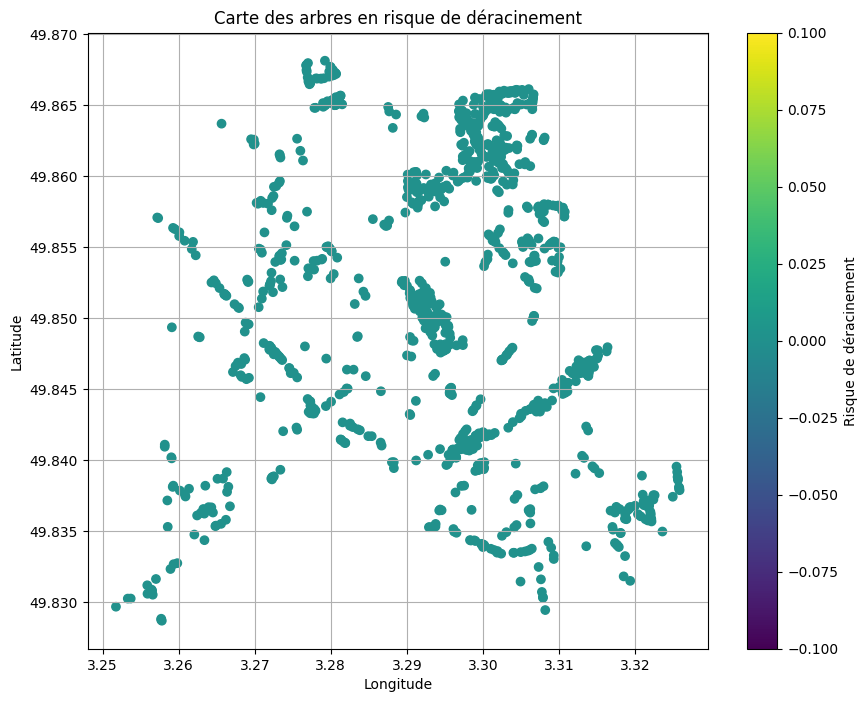

In [9]:
# Chargement du meilleur modèle
model_file = 'best_sgd_model.pkl'
with open(model_file, 'rb') as file:
    best_sgd_model = pickle.load(file)

# Chargement des données JSON de test
data_json_file = 'test_data.json'
with open(data_json_file, 'r') as file:
    data_json = json.load(file)


data_map = pd.DataFrame(data_json)
#print(data_map.isna().sum())
data_map = data_map[best_sgd_model.feature_names_in_]

predictions_sgd = best_sgd_model.predict(data_map) # prédictions sur l'ensemble de test
result_df = pd.DataFrame({'longitude': data_map['longitude'], 'latitude': data_map['latitude'], 'prediction': predictions_sgd})
print("Nombre d'arbres à risque de déracinement :", result_df['prediction'].sum())

plt.figure(figsize=(10, 8))
sc = plt.scatter(result_df['longitude'], result_df['latitude'], c=result_df['prediction'], marker='o', label='Arbres à risque')
plt.colorbar(sc, label='Risque de déracinement')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Carte des arbres en risque de déracinement')
plt.grid(True)
plt.show()

fig = px.scatter_mapbox(
    result_df,
    lat='latitude',
    lon='longitude',
    color='prediction',
    title='Carte des arbres en risque de déracinement à Saint-Quentin'
)

fig.update_layout(
    mapbox=dict(
        center=dict(lat=49.8489, lon=3.2876),
        zoom=13
    ),
    mapbox_style='open-street-map',
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

fig.show()

      longitude   latitude  haut_tot  haut_tronc  tronc_diam  age_estim
0      3.301635  49.865548  1.001937    1.202070    0.108097   0.046213
1      3.272708  49.847591 -0.610010   -0.474180   -0.350711  -0.730176
2      3.309938  49.854962  0.518353   -1.032930    0.923755   0.305009
3      3.290565  49.859053 -0.448816   -0.474180    0.668862   0.201491
4      3.299023  49.834308  0.518353    0.084570    0.159075   0.305009
...         ...        ...       ...         ...         ...        ...
1107   3.302374  49.862184  0.034768    0.084570   -0.690569  -0.730176
1108   3.269194  49.849572 -1.093594   -1.591681   -1.285320  -0.988972
1109   3.279423  49.855017  0.195963    0.643320   -0.350711  -0.212583
1110   3.306403  49.855163 -0.771205   -0.474180   -1.370285  -1.506565
1111   3.294365  49.840780 -1.093594   -0.474180   -1.302313  -0.988972

[1112 rows x 6 columns]


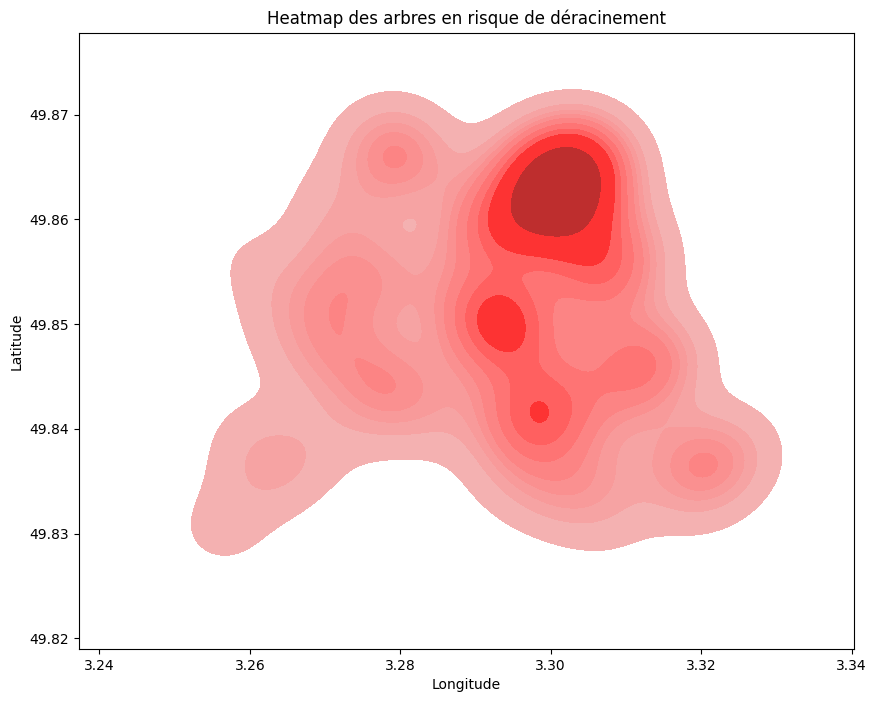

In [10]:
print(data_map)
plt.figure(figsize=(10, 8))
sns.kdeplot(data=result_df, x='longitude', y='latitude', fill=True, color='red')
plt.title('Heatmap des arbres en risque de déracinement')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but SGDClassifier was fitted with feature names



Nombre d'arbres à risque de déracinement : 0
Score d'exactitude sur l'ensemble d'entraînement : 0.9769165607793308
Score d'exactitude sur l'ensemble de validation : 0.9758730158730159
Score d'exactitude sur l'ensemble de test : 0.9838129496402878


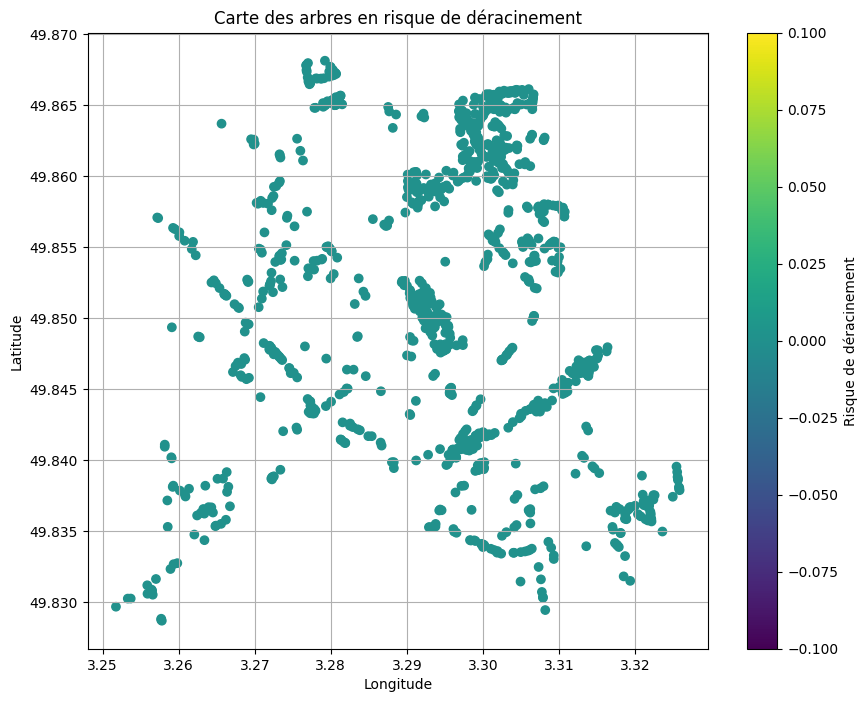